In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from CinemaNet.train_utils import *
from CinemaNet.custom_head import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *

import wandb

In [3]:
#hide
wandb.init(name='MM-MNet-3rd',
           project='shot-framing',
           tags=['MobileNetV2', 'MixMatch', 'fastai', 'PyTorch'],
           entity='synopsis',
           reinit=True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/synopsis/shot-framing/runs/0dhgz4hx

In [4]:
#hide
%env WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'

env: WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'


## Setup

In [5]:
path = Path('/home/rahul/github_projects/CinemaNet/')

In [6]:
config = wandb.config

config.img_size=to_film_ar(150)
config.batch_size=64
config.model='MobileNetV2'
config.mixup='True'
config.mixmatch='True'

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


In [7]:
data = ImageDataBunch.from_folder(path, 
                                  train='valid', valid='train', # swapping train & valid datasets
                                  bs = config.batch_size,
                                  size = tuple(config.img_size),
                                  ds_tfms = get_tfms(config.img_size[0]),
                                  resize_method = ResizeMethod.SQUISH
                                 ).normalize(imagenet_stats) 

In [8]:
data.c
data

6

ImageDataBunch;

Train: LabelList (600 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium,Medium,Medium
Path: /home/rahul/github_projects/CinemaNet;

Valid: LabelList (5505 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium,Medium,Medium
Path: /home/rahul/github_projects/CinemaNet;

Test: None

In [9]:
data_unlabelled = ImageList.from_folder(path/'filmgrab')
data_unlabelled

ImageList (95329 items)
Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024)
Path: /home/rahul/github_projects/CinemaNet/filmgrab

In [10]:
config.valid_size = len(data.valid_ds)
config.train_size = len(data.train_ds)
config.unlabelled_size = len(data_unlabelled)

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


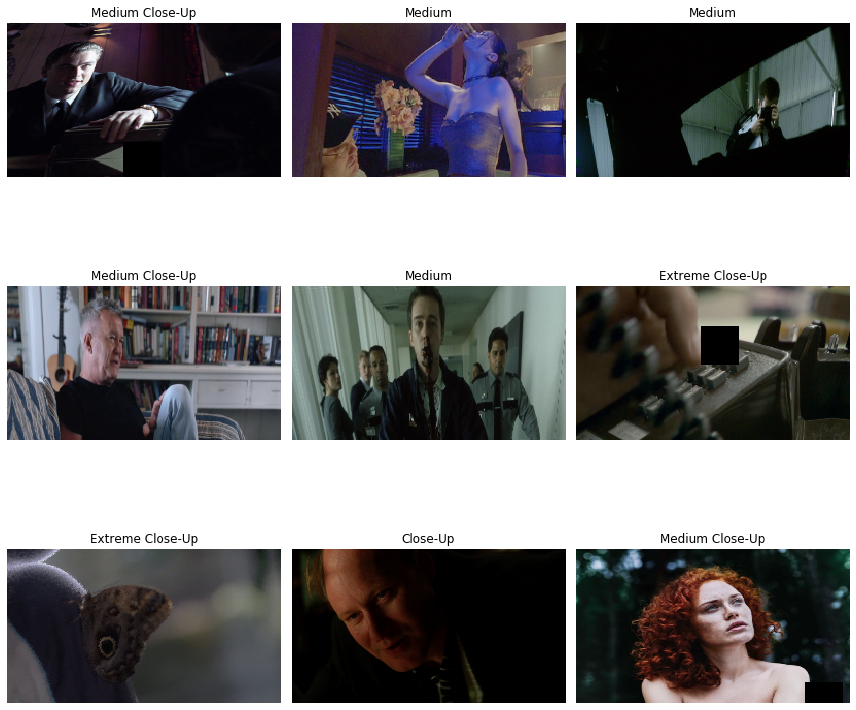

In [11]:
data.show_batch(rows=3)

## MixMatch

In [12]:
arch = models.mobilenet_v2
learn = cnn_learner(data, arch, pretrained=True, metrics=metrics).mixmatch(data_unlabelled, α=.75, λ=75, size=config.img_size)

In [13]:
learn.data

ImageDataBunch;

Train: MultiTfmLabelList (95329 items)
x: ImageList
[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)]
y: EmptyLabelList
,,,,
Path: /home/rahul/github_projects/CinemaNet/filmgrab;

Valid: LabelList (5505 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium,Medium,Medium
Path: /home/rahul/github_projects/CinemaNet;

Test: None

labeled dataset     :           600 samples
unlabeled dataset   :        95,329 samples
total train samples :       285,888 samples


epoch,train_loss,valid_loss,accuracy,precision,recall,train_Lx,train_Lu*λ,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


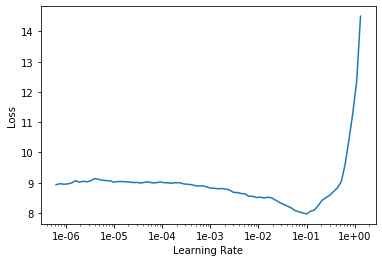

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='epoch', name=f'{mod_name}', monitor=monitor),
        #SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_val_loss', monitor='valid_loss'),
        #SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_accuracy', monitor='accuracy')
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

In [16]:
model_name = 'MobileNetV2-img_150-MixMatch_run3'

# log every epoch -- sometimes, minor improvements in valid_loss/accuracy come with a massive
# drop in train_loss, which IMO is sub-optimal. It's better to pick up training from a point
# where both train and valid loss are not too low and then unfreeze and retrain
callbacks = get_callbacks(learn, model_name, patience=4, monitor='valid_loss')

In [17]:
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.508619,1.423283,0.430336,0.512020,0.426350,00:58
1,1.869424,0.910811,0.671390,0.694837,0.689843,00:53
2,1.519098,0.907031,0.707720,0.723151,0.719564,00:55
3,1.264005,0.884315,0.722071,0.737611,0.739886,00:54
4,1.057686,0.866967,0.725522,0.736950,0.745240,00:52
5,0.939292,0.842136,0.728247,0.736048,0.745538,00:53
6,0.856672,0.844232,0.730790,0.740070,0.749046,00:59


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with valid_loss value: 1.4232834577560425.
Better model found at epoch 1 with valid_loss value: 0.9108107686042786.
Better model found at epoch 2 with valid_loss value: 0.9070309996604919.
Better model found at epoch 3 with valid_loss value: 0.8843145966529846.
Better model found at epoch 4 with valid_loss value: 0.8669672012329102.
Better model found at epoch 5 with valid_loss value: 0.8421359062194824.
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200118_051106-0dhgz4hx/bestmodel.pth


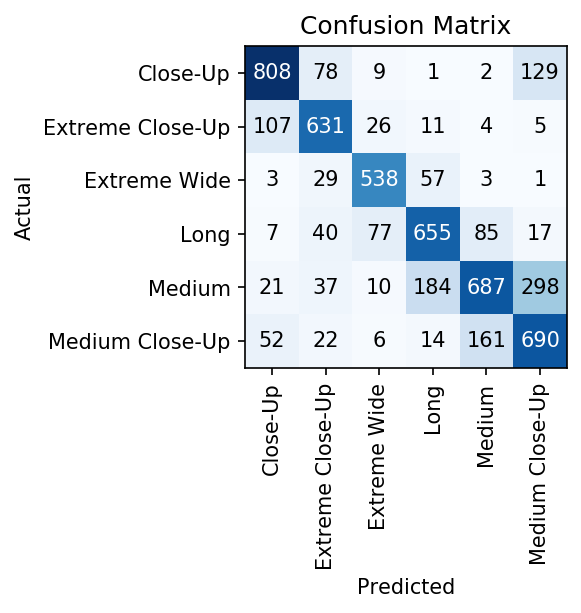

In [18]:
learn.fit_one_cycle(7, 1e-3, callbacks=callbacks)

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


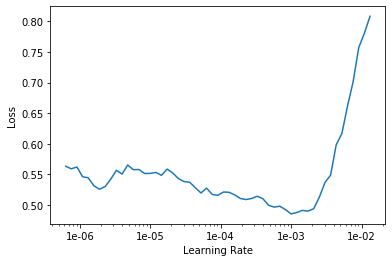

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
model_name = 'MobileNetV2-img_150-MixMatch_run3-unfrozen'
callbacks = get_callbacks(learn, model_name, patience=4, monitor='valid_loss')

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.564539,0.837394,0.730064,0.735702,0.748440,00:57
1,0.580507,0.827369,0.731153,0.736887,0.748757,00:57
2,0.568696,0.825230,0.733515,0.739590,0.751101,00:58
3,0.536107,0.815730,0.735150,0.741205,0.751599,00:56
4,0.546635,0.803501,0.737875,0.741348,0.754069,00:57
5,0.516812,0.793988,0.739510,0.742085,0.754024,00:58
6,0.490734,0.781193,0.743324,0.746342,0.756046,00:57
7,0.471560,0.776792,0.746049,0.748440,0.759826,00:57
8,0.468985,0.769947,0.748774,0.752323,0.763782,00:57
9,0.454404,0.767918,0.748955,0.752201,0.764416,00:54


Better model found at epoch 0 with valid_loss value: 0.8373937606811523.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 1 with valid_loss value: 0.8273687362670898.
Better model found at epoch 2 with valid_loss value: 0.8252302408218384.
Better model found at epoch 3 with valid_loss value: 0.8157296776771545.
Better model found at epoch 4 with valid_loss value: 0.8035013675689697.
Better model found at epoch 5 with valid_loss value: 0.7939879894256592.
Better model found at epoch 6 with valid_loss value: 0.7811928987503052.
Better model found at epoch 7 with valid_loss value: 0.7767924666404724.
Better model found at epoch 8 with valid_loss value: 0.769946813583374.
Better model found at epoch 9 with valid_loss value: 0.7679181098937988.
Better model found at epoch 10 with valid_loss value: 0.7650341987609863.
Better model found at epoch 12 with valid_loss value: 0.7624037861824036.
Better model found at epoch 13 with valid_loss value: 0.7544019818305969.
Better model found at epoch 15 with valid_loss value: 0.7489274740219116.
Better model found at epoch 16 with valid_loss v

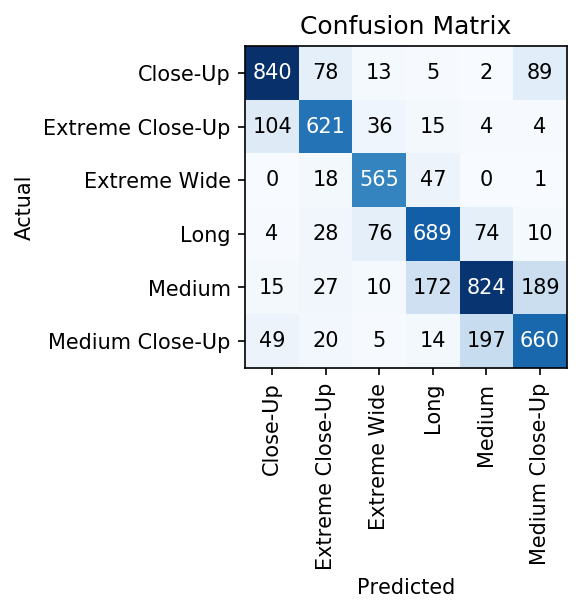

In [22]:
learn.fit_one_cycle(25, slice(1e-6, 1e-4), callbacks=callbacks)